In [1]:
import json
import os
import time
from functools import partial

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from monai.config import print_config
from monai.data import (CacheDataset, Dataset, DataLoader, decollate_batch)
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import PatchEmbed, UnetrBasicBlock
from monai.networks.nets import UNETR, SwinUNETR
from monai.transforms import (Activations, AsDiscrete, Compose,
                              CropForegroundd, EnsureChannelFirstd, LoadImaged,
                              Orientationd, RandCropByPosNegLabeld, RandFlipd,
                              RandRotate90d, RandShiftIntensityd,
                              ScaleIntensityRanged, Spacingd, ToTensord, 
                              ConvertToMultiChannelBasedOnBratsClassesd, RandSpatialCropd,
                              NormalizeIntensityd, RandScaleIntensityd)
from monai.utils.enums import MetricReduction
from tqdm import tqdm
from monai.networks.nets.swin_unetr import SwinUNETRCoAttn

In [2]:
DATA_DIR = "/scratch/MSD/"
MODEL_DIR = "/scratch/MSD/logs/pre_train/swin/runs/"
LOG_DIR = "/scratch/MSD/logs/fine_tune/"
JSON_DIR = LOG_DIR + "brats21_folds.json"

use_pretrained = True
pretrained_path = os.path.normpath(MODEL_DIR + "model_bestValRMSE.pt")
DEVICE_IDS = [0, 1]

In [3]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(LOG_DIR, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [4]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = CacheDataset(data=train_files, transform=train_transform, cache_rate=0.01)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=False,
        drop_last=False
    )
    val_ds = CacheDataset(data=validation_files, transform=val_transform, cache_rate=0.2)
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=False,
        drop_last=False
    )

    return train_loader, val_loader

In [5]:
roi = (96, 96, 96)
batch_size = 4
sw_batch_size = 16
fold = 0
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader = get_loader(batch_size, DATA_DIR, JSON_DIR, fold, roi)

image shape: (240, 240, 155), label shape: (240, 240, 155)


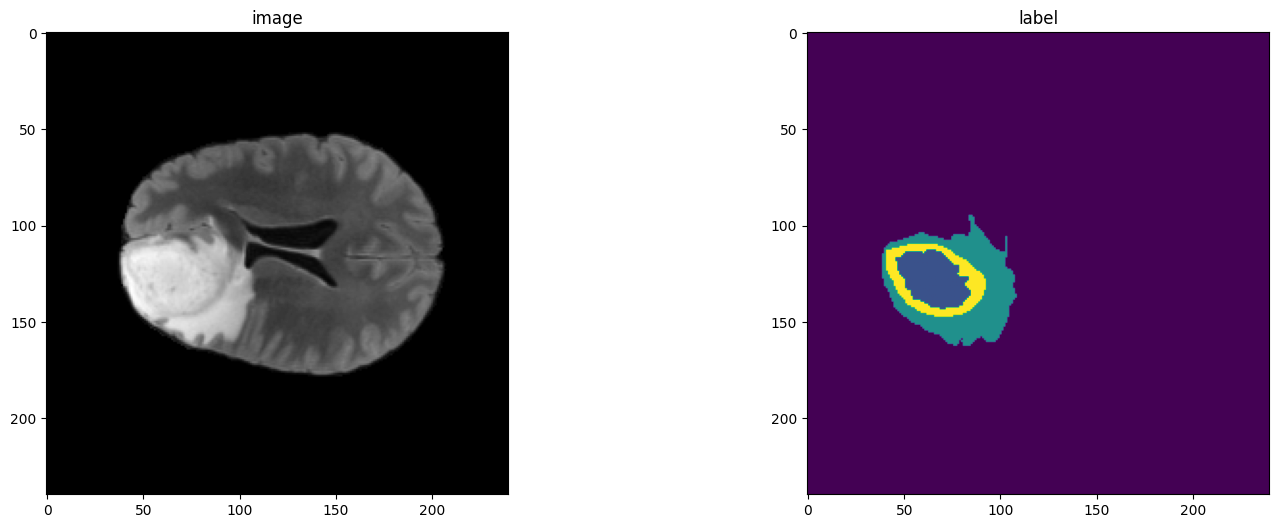

In [6]:
img_add = os.path.join(DATA_DIR, "TrainingData/BraTS2021_00006/BraTS2021_00006_flair.nii.gz")
label_add = os.path.join(DATA_DIR, "TrainingData/BraTS2021_00006/BraTS2021_00006_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETRCoAttn(
    img_size=roi,
    in_channels=1,
    out_channels=3,
    feature_size=48,
    drop_rate=0.25,
    attn_drop_rate=0.2,
    dropout_path_rate=0.0,
)

if use_pretrained is True:
    print("Loading Weights from the Path {}".format(pretrained_path))
    weights = torch.load(pretrained_path)
    old_sd = weights["state_dict"].keys()
    new_sd = {}
    for k in old_sd:
        new_sd[k.replace("module.", "")] = weights["state_dict"][k]

    model.load_state_dict(new_sd, strict=False)

    model.swinViT.patch_embed = PatchEmbed(
                patch_size=model.swinViT.patch_size,
                in_chans=4,
                embed_dim=48,
                norm_layer=nn.LayerNorm,
                spatial_dims=3
    )
    model.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=4,
            out_channels=48,
            kernel_size=3,
            stride=1,
            norm_name="instance",
            res_block=True,
    )
    del weights, new_sd, old_sd
    print("Pretrained Weights Succesfully Loaded !")

Loading Weights from the Path /scratch/MSD/logs/pre_train/swin/runs/model_bestValRMSE.pt
Pretrained Weights Succesfully Loaded !


In [7]:
weights = torch.load("/scratch/MSD/logs/fine_tune/run2_swin_ft_top.pt")
old_sd = weights["state_dict"].keys()
new_sd = {}
for k in old_sd:
    new_sd[k.replace("module.", "")] = weights["state_dict"][k]

model.load_state_dict(new_sd)

<All keys matched successfully>

In [8]:
model = nn.DataParallel(model, device_ids = DEVICE_IDS)
model.to(device)

torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [9]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        # print(
        #     "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
        #     "loss: {:.4f}".format(run_loss.avg),
        #     "time {:.2f}s".format(time.time() - start_time),
        # )
        start_time = time.time()
    return run_loss.avg


def val_epoch(model, loader, epoch, acc_func, model_inferer=None, 
              post_sigmoid=None, post_pred=None,):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [10]:
def trainer(model, train_loader, val_loader, optimizer, loss_func, 
            acc_func, scheduler, model_inferer=None, start_epoch=0, 
            post_sigmoid=None, post_pred=None,):
    print(time.ctime())
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        # print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    filename=f"run2_swin_ft_check.pt",
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

In [ ]:
print("val_acc", val_acc_max)
print("dices_tc",dices_tc)
print("dices_wt",dices_wt)
print("dices_wt",dices_et)
print("dices_avg",dices_avg)
print("loss_epochs",loss_epochs)
print("trains_epochs",trains_epoch)

In [ ]:
save_checkpoint(model, 1000, filename="ft_full.pt", best_acc=val_acc_max)

In [8]:
case_num = "00650"

test_files = [
    {
        "image": [
            os.path.join(
                DATA_DIR,
                "TrainingData/BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii.gz",
            ),
            os.path.join(
                DATA_DIR,
                "TrainingData/BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t1ce.nii.gz",
            ),
            os.path.join(
                DATA_DIR,
                "TrainingData/BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t1.nii.gz",
            ),
            os.path.join(
                DATA_DIR,
                "TrainingData/BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            DATA_DIR,
            "TrainingData/BraTS2021_"
            + case_num
            + "/BraTS2021_"
            + case_num
            + "_seg.nii.gz",
        ),
    }
]

test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = Dataset(data=test_files, transform=test_transform)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [13]:
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from collections.abc import Sequence
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.networks.nets.swin_unetr import SwinTransformerCoAttn
from monai.networks.nets.swin_unetr import PatchMerging, PatchMergingV2
MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}

class CALFKN(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_size = ensure_tuple_rep(2, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        for m, p in zip(img_size, patch_size):
            for i in range(5):
                if m % np.power(p, i + 1) != 0:
                    raise ValueError("input image size (img_size) should be divisible by stage-wise image resolution.")

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.swinViT = SwinTransformerCoAttn(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_size,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)

    def forward(self, x_in):
        hidden_states_out = self.swinViT(x_in, self.normalize)
        return hidden_states_out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CALFKN(
    img_size=roi,
    in_channels=1,
    out_channels=3,
    feature_size=48,
    drop_rate=0.25,
    attn_drop_rate=0.2,
    dropout_path_rate=0.0,
)

if use_pretrained is True:
    print("Loading Weights from the Path {}".format(pretrained_path))
    weights = torch.load(pretrained_path)
    old_sd = weights["state_dict"].keys()
    new_sd = {}
    for k in old_sd:
        new_sd[k.replace("module.", "")] = weights["state_dict"][k]

    model.load_state_dict(new_sd, strict=False)

    model.swinViT.patch_embed = PatchEmbed(
                patch_size=model.swinViT.patch_size,
                in_chans=4,
                embed_dim=48,
                norm_layer=nn.LayerNorm,
                spatial_dims=3
    )
    model.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=4,
            out_channels=48,
            kernel_size=3,
            stride=1,
            norm_name="instance",
            res_block=True,
    )
    del weights, new_sd, old_sd
    print("Pretrained Weights Succesfully Loaded !")

weights = torch.load(os.path.join("/scratch/MSD/logs/fine_tune/run2_swin_ft_top.pt"))
old_sd = weights["state_dict"].keys()
new_sd = {}
for k in old_sd:
    new_sd[k.replace("module.", "")] = weights["state_dict"][k]

model.load_state_dict(new_sd)
model.to(device)

In [ ]:
def get_seg_map(pt_path):
    weights = torch.load(os.path.join(pt_path))
    old_sd = weights["state_dict"].keys()
    new_sd = {}
    for k in old_sd:
        new_sd[k.replace("module.", "")] = weights["state_dict"][k]

    model.load_state_dict(new_sd)
    model.to(device)
    model.eval()

    model_inferer_test = partial(
        sliding_window_inference,
        roi_size=[roi[0], roi[1], roi[2]],
        sw_batch_size=1,
        predictor=model,
        overlap=0.6,
    )


    with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            image = batch_data["image"].cuda()
            print("image shape:", image.shape)
            prob = torch.sigmoid(model_inferer_test(image))
            seg = prob[0].detach().cpu().numpy()
            seg = (seg > 0.5).astype(np.int8)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[1] == 1] = 2
            seg_out[seg[0] == 1] = 1
            seg_out[seg[2] == 1] = 4
    return seg_out

seg_out_run1 = get_seg_map("/scratch/MSD/logs/fine_tune/run3_UNet_ft_top.pt")
seg_out_run2 = get_seg_map("/scratch/MSD/logs/fine_tune/run1_SwinUnetTr_ft_top.pt")
seg_out_run3 = get_seg_map("/scratch/MSD/logs/fine_tune/run2_fuse_ft_top.pt")
seg_out_run4 = get_seg_map("/scratch/MSD/logs/fine_tune/run3_fuse_ft_top.pt")

In [106]:
case_num = "00650"
DATA_DIR = "/scratch/MSD/"
img_add = os.path.join(
    DATA_DIR,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
)
label_add = os.path.join(
    DATA_DIR,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()

(<matplotlib.image.AxesImage at 0x7f93648d5350>, 113)

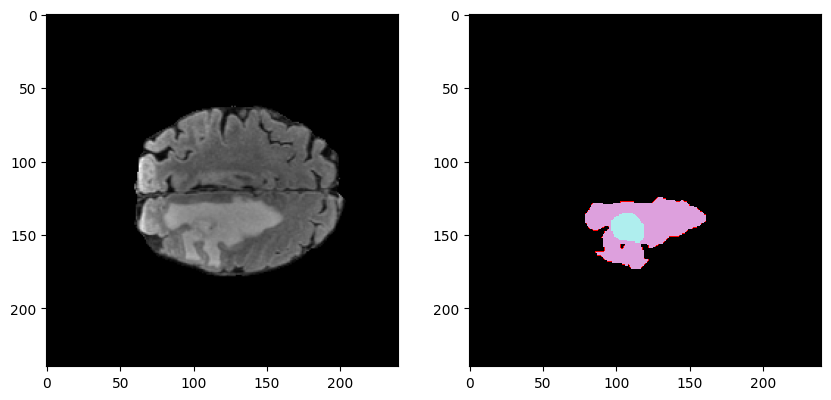

In [122]:
import matplotlib as mpl
img = (img - np.min(img)) / (np.max(img) - np.min(img))

c = mpl.colors.ListedColormap(['black', 'red', 'plum', 'paleturquoise'])
n = mpl.colors.Normalize(vmin=0,vmax=3)

idx = np.random.randint(0, img.shape[-1])
plt.figure("image", (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(label[:, :, idx], cmap=c, norm=n), idx

In [92]:
def plots(idx):
    fig, axs = plt.subplots(1, 6, figsize=(15, 5))
    axs[0].imshow(img[:, :, idx], cmap="bone")
    axs[0].set_title("Image")
    axs[0].axis("off")
    axs[1].imshow(label[:, :, idx])
    axs[1].set_title("Label")
    axs[1].axis("off")
    axs[2].imshow(seg_out_run1[:, :, idx], cmap="inferno")
    axs[2].set_title("UNet")
    axs[2].axis("off")
    axs[3].imshow(seg_out_run2[:, :, idx], cmap="inferno")
    axs[3].set_title("SwinUnetTr")
    axs[3].axis("off")
    axs[4].imshow(seg_out_run3[:, :, idx], cmap="inferno")
    axs[4].set_title("Ours1")
    axs[4].axis("off")
    axs[5].imshow(seg_out_run4[:, :, idx], cmap="inferno")
    axs[5].set_title("Ours2")
    axs[5].axis("off")
    plt.tight_layout()

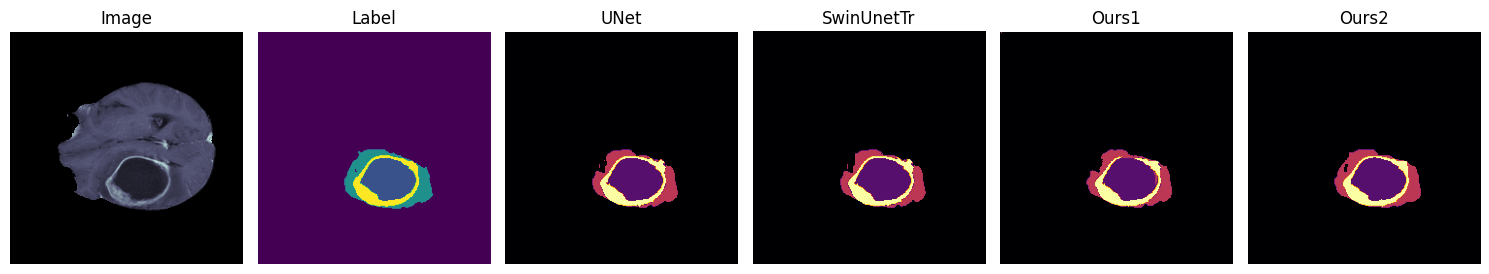

In [66]:
plots(np.random.randint(0, img.shape[2]))

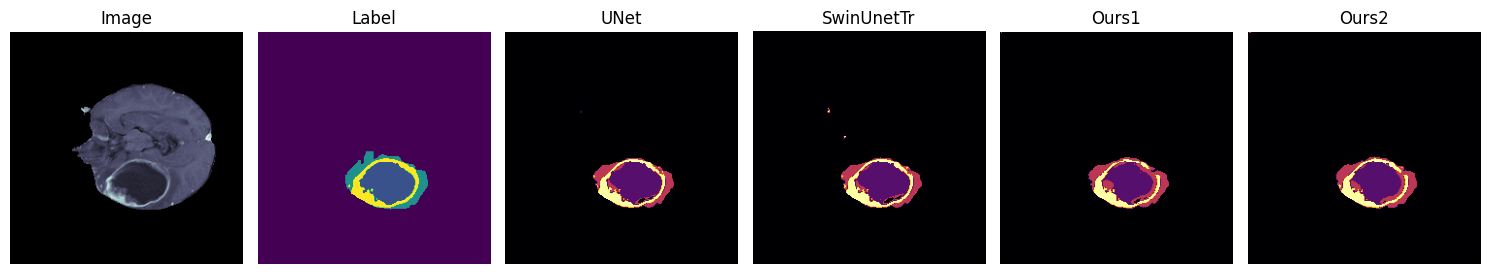

In [76]:
plots(np.random.randint(0, img.shape[2]))

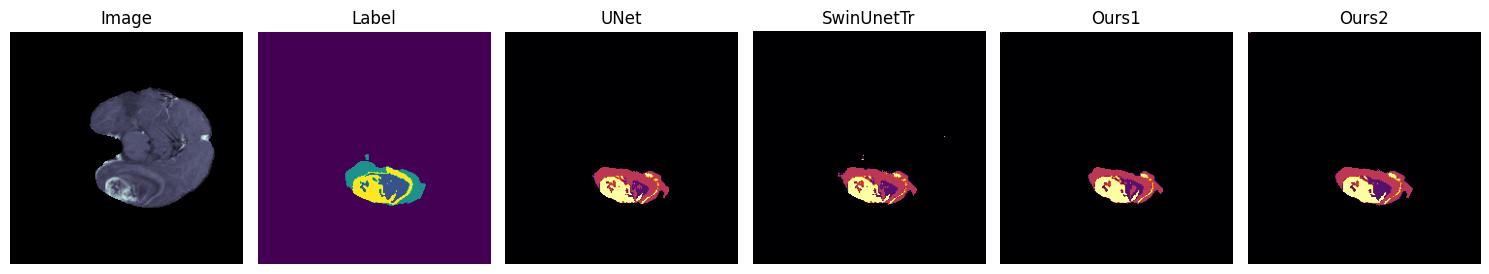

In [95]:
plots(np.random.randint(0, img.shape[2]))

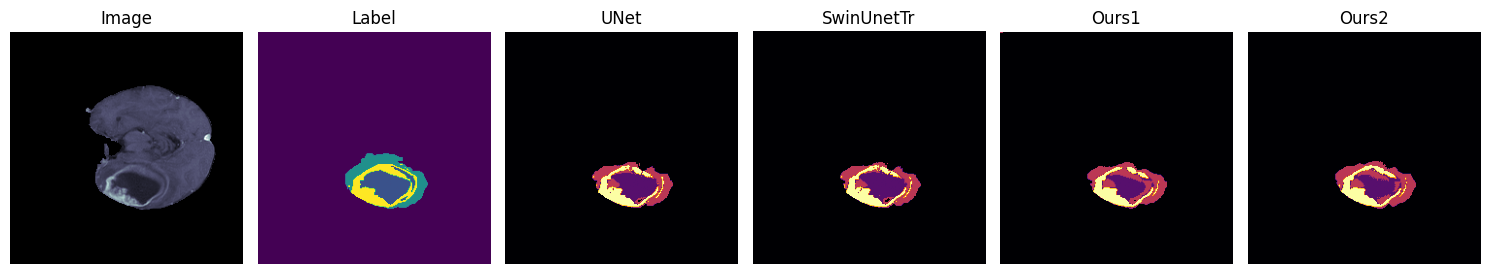

In [117]:
plots(np.random.randint(0, img.shape[2]))